# Customer segmentation (clustering)
## Hotel Customer Data
### This notebook was developed by:

- João Venichand - 20211644
- Gonçalo Custódio - 20211643
- Diogo Correia - 20211586
- Duarte Emanuel - 200564

### Data Description
Dataset related to customer behavior and preferences in a hotel context. Contains historical booking patterns, revenue data, and customer-specific preferences.

#### Customer Information:
- **ID**: Unique customer identifier (numeric)
- **Nationality**: Customer nationality (categorical: e.g., 'BRA', 'USA')
- **Age**: Customer age (numeric)
- **DaysSinceCreation**: Days since the customer account was created (numeric)
- **NameHash**: Anonymized hash of the customer’s name (text)
- **DocIDHash**: Anonymized hash of the customer’s ID document (text)
- **LodgingRevenue**: Total lodging revenue (numeric)
- **OtherRevenue**: Total revenue from non-lodging services (e.g., food, spa) (numeric)
- **MarketSegment**: Customer market segment (e.g., 'corporate', 'leisure') (categorical)

#### Booking Behaviour:
- **AverageLeadTime**: Average days between booking and arrival date (numeric)
- **BookingsCanceled**: Total canceled bookings by the customer (numeric)
- **BookingsNoShowed**: Total "no-show" bookings (numeric)
- **BookingsCheckedin**: Total bookings that resulted in stays (numeric)
- **PersonNights**: Total person-nights stayed (adults + children × nights) (numeric)
- **RoomNights**: Total room-nights stayed (rooms × nights) (numeric)
- **DistributionChannel**: Booking distribution channel (e.g., 'direct', 'agency') (categorical)

#### Customer Preferences (Binary: 0 = No, 1 = Yes)
- **SRHighFloor**: Requests rooms on higher floors
- **SRLowFloor**: Requests rooms on lower floors
- **SRMediumFloor**: Requests rooms on middle floors
- **SRAccessibleRoom**: Requests accessible rooms
- **SRBathtub**: Requests rooms with bathtubs
- **SRShower**: Requests rooms with showers
- **SRCrib**: Requests cribs
- **SRKingSizeBed**: Requests king-size beds
- **SRTwinBed**: Requests twin beds
- **SRNearElevator**: Requests rooms near elevators
- **SRAwayFromElevator**: Requests rooms away from elevators
- **SRNoAlcoholInMiniBar**: Requests mini-bars without alcohol
- **SRQuietRoom**: Requests quiet rooms

## Importing Libraries


In [300]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
import umap
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Understanding 


Import the dataset, storing it in the data frame **data**.

In [301]:
data = pd.read_csv('Case1_HotelCustomerSegmentation.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111733 entries, 0 to 111732
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    111733 non-null  int64  
 1   Nationality           111733 non-null  object 
 2   Age                   107561 non-null  float64
 3   DaysSinceCreation     111733 non-null  int64  
 4   NameHash              111733 non-null  object 
 5   DocIDHash             110732 non-null  object 
 6   AverageLeadTime       111733 non-null  int64  
 7   LodgingRevenue        111733 non-null  float64
 8   OtherRevenue          111733 non-null  float64
 9   BookingsCanceled      111733 non-null  int64  
 10  BookingsNoShowed      111733 non-null  int64  
 11  BookingsCheckedIn     111733 non-null  int64  
 12  PersonsNights         111733 non-null  int64  
 13  RoomNights            111733 non-null  int64  
 14  DistributionChannel   111733 non-null  object 
 15  

Display the data.

In [302]:
data.head(5)

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,1,PRT,52.0,440,0x2C371FD6CE12936774A139FD7430C624F1C4D5109CE6...,0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...,59,292.0,82.3,1,...,0,0,0,0,0,0,0,0,0,0
1,2,PRT,NaN,1385,0x198CDB98BF37B6E23F9548C56A88B00912D65A9AA0D6...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,61,280.0,53.0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,DEU,32.0,1385,0xDA46E62F66936284DF2844EC4FC542D0DAD780C0EE0C...,0x27F5DF762CCDA622C752CCDA45794923BED9F1B66300...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,FRA,61.0,1385,0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...,0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...,93,240.0,60.0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,FRA,52.0,1385,0xD2E3D5BFCA141865669F98D64CDA85AD04DEFF47F8A0...,0x42BDEE0E05A9441C94147076EDDCC47E604DA5447DD4...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


Turn the ID into the index of the data.

In [303]:
if data['ID'].duplicated().any():
    print("There are duplicate IDs in the dataset.")
else:
    data.set_index('ID', inplace=True)

Summary statistics for all variables

In [304]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Nationality,111733,199,FRA,16516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,107561.0,NaN,NaN,NaN,45.639191,17.244952,-10.0,33.0,47.0,58.0,123.0
DaysSinceCreation,111733.0,NaN,NaN,NaN,595.026599,374.657382,36.0,288.0,522.0,889.0,1385.0
NameHash,111733,107584,0x15A713CE687991691A18F6CDC56ABE24979C73CF5D51...,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DocIDHash,110732,103480,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,3032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AverageLeadTime,111733.0,NaN,NaN,NaN,60.833147,85.11532,-1.0,0.0,21.0,95.0,588.0
LodgingRevenue,111733.0,NaN,NaN,NaN,283.851283,379.131556,0.0,0.0,208.0,393.3,21781.0
OtherRevenue,111733.0,NaN,NaN,NaN,64.682802,123.580715,0.0,0.0,31.0,84.0,8859.25
BookingsCanceled,111733.0,NaN,NaN,NaN,0.002282,0.080631,0.0,0.0,0.0,0.0,15.0
BookingsNoShowed,111733.0,NaN,NaN,NaN,0.0006,0.028217,0.0,0.0,0.0,0.0,3.0


Check missing values

In [305]:
print(data.isnull().sum())

Nationality                0
Age                     4172
DaysSinceCreation          0
NameHash                   0
DocIDHash               1001
AverageLeadTime            0
LodgingRevenue             0
OtherRevenue               0
BookingsCanceled           0
BookingsNoShowed           0
BookingsCheckedIn          0
PersonsNights              0
RoomNights                 0
DistributionChannel        0
MarketSegment              0
SRHighFloor                0
SRLowFloor                 0
SRAccessibleRoom           0
SRMediumFloor              0
SRBathtub                  0
SRShower                   0
SRCrib                     0
SRKingSizeBed              0
SRTwinBed                  0
SRNearElevator             0
SRAwayFromElevator         0
SRNoAlcoholInMiniBar       0
SRQuietRoom                0
dtype: int64


Duplicated data

In [306]:
duplicated_clients = data['DocIDHash'].value_counts()
duplicated_clients = duplicated_clients[duplicated_clients > 1].index
data = data[~data['DocIDHash'].isin(duplicated_clients) & data['DocIDHash'].notna()]

print(f"Final dataset size after removing duplicate and missing DocIDHash: {data.shape[0]} rows")

Final dataset size after removing duplicate and missing DocIDHash: 100395 rows


Histograms of numeric variables

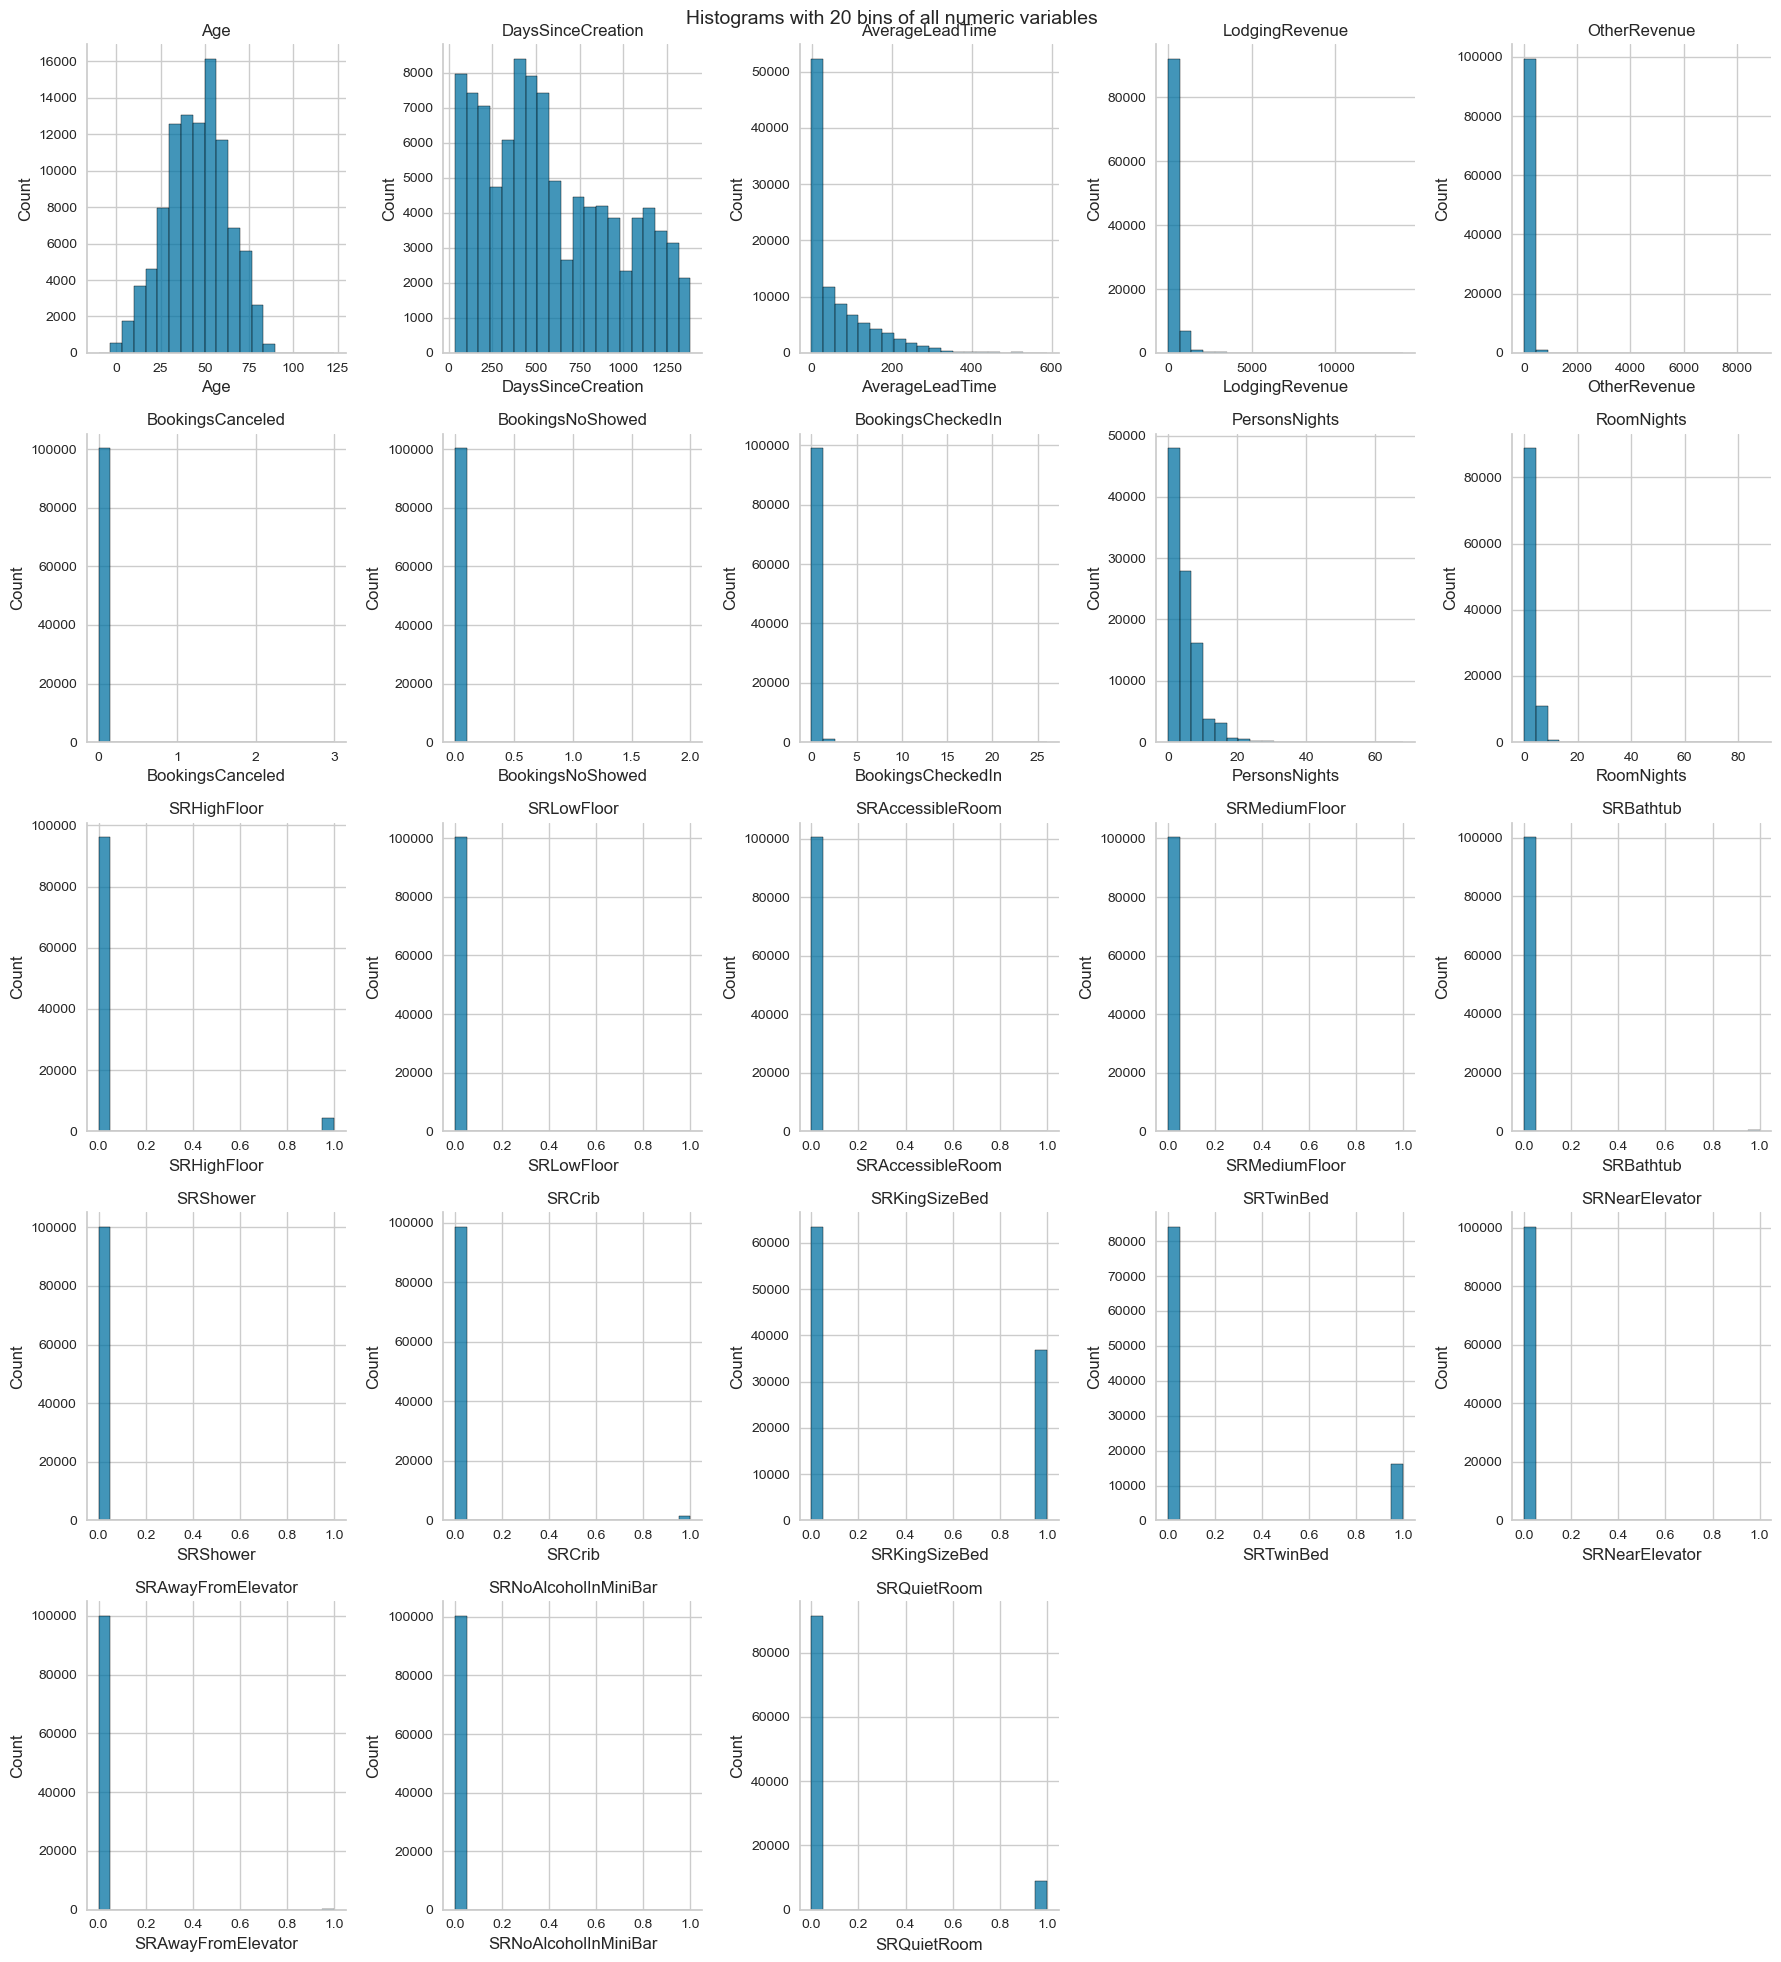

In [307]:
subPlots_label_fontSize = 12
plots_Title_fontSize = 14
numerical_data = data.select_dtypes(include=[np.number]).columns.tolist()
num_vars = len(numerical_data)
num_cols = 5
num_rows = (num_vars // num_cols) + (1 if num_vars % num_cols != 0 else 0)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
ax = ax.flatten()

for i, var in enumerate(numerical_data):
    sns.histplot(data=data,
                 bins=20,
                 x=var,
                 ax=ax[i],
                 kde=False)
    ax[i].set_title(var, fontsize=subPlots_label_fontSize)

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=plots_Title_fontSize)
plt.tight_layout()
plt.show()

Boxplot of numeric variables

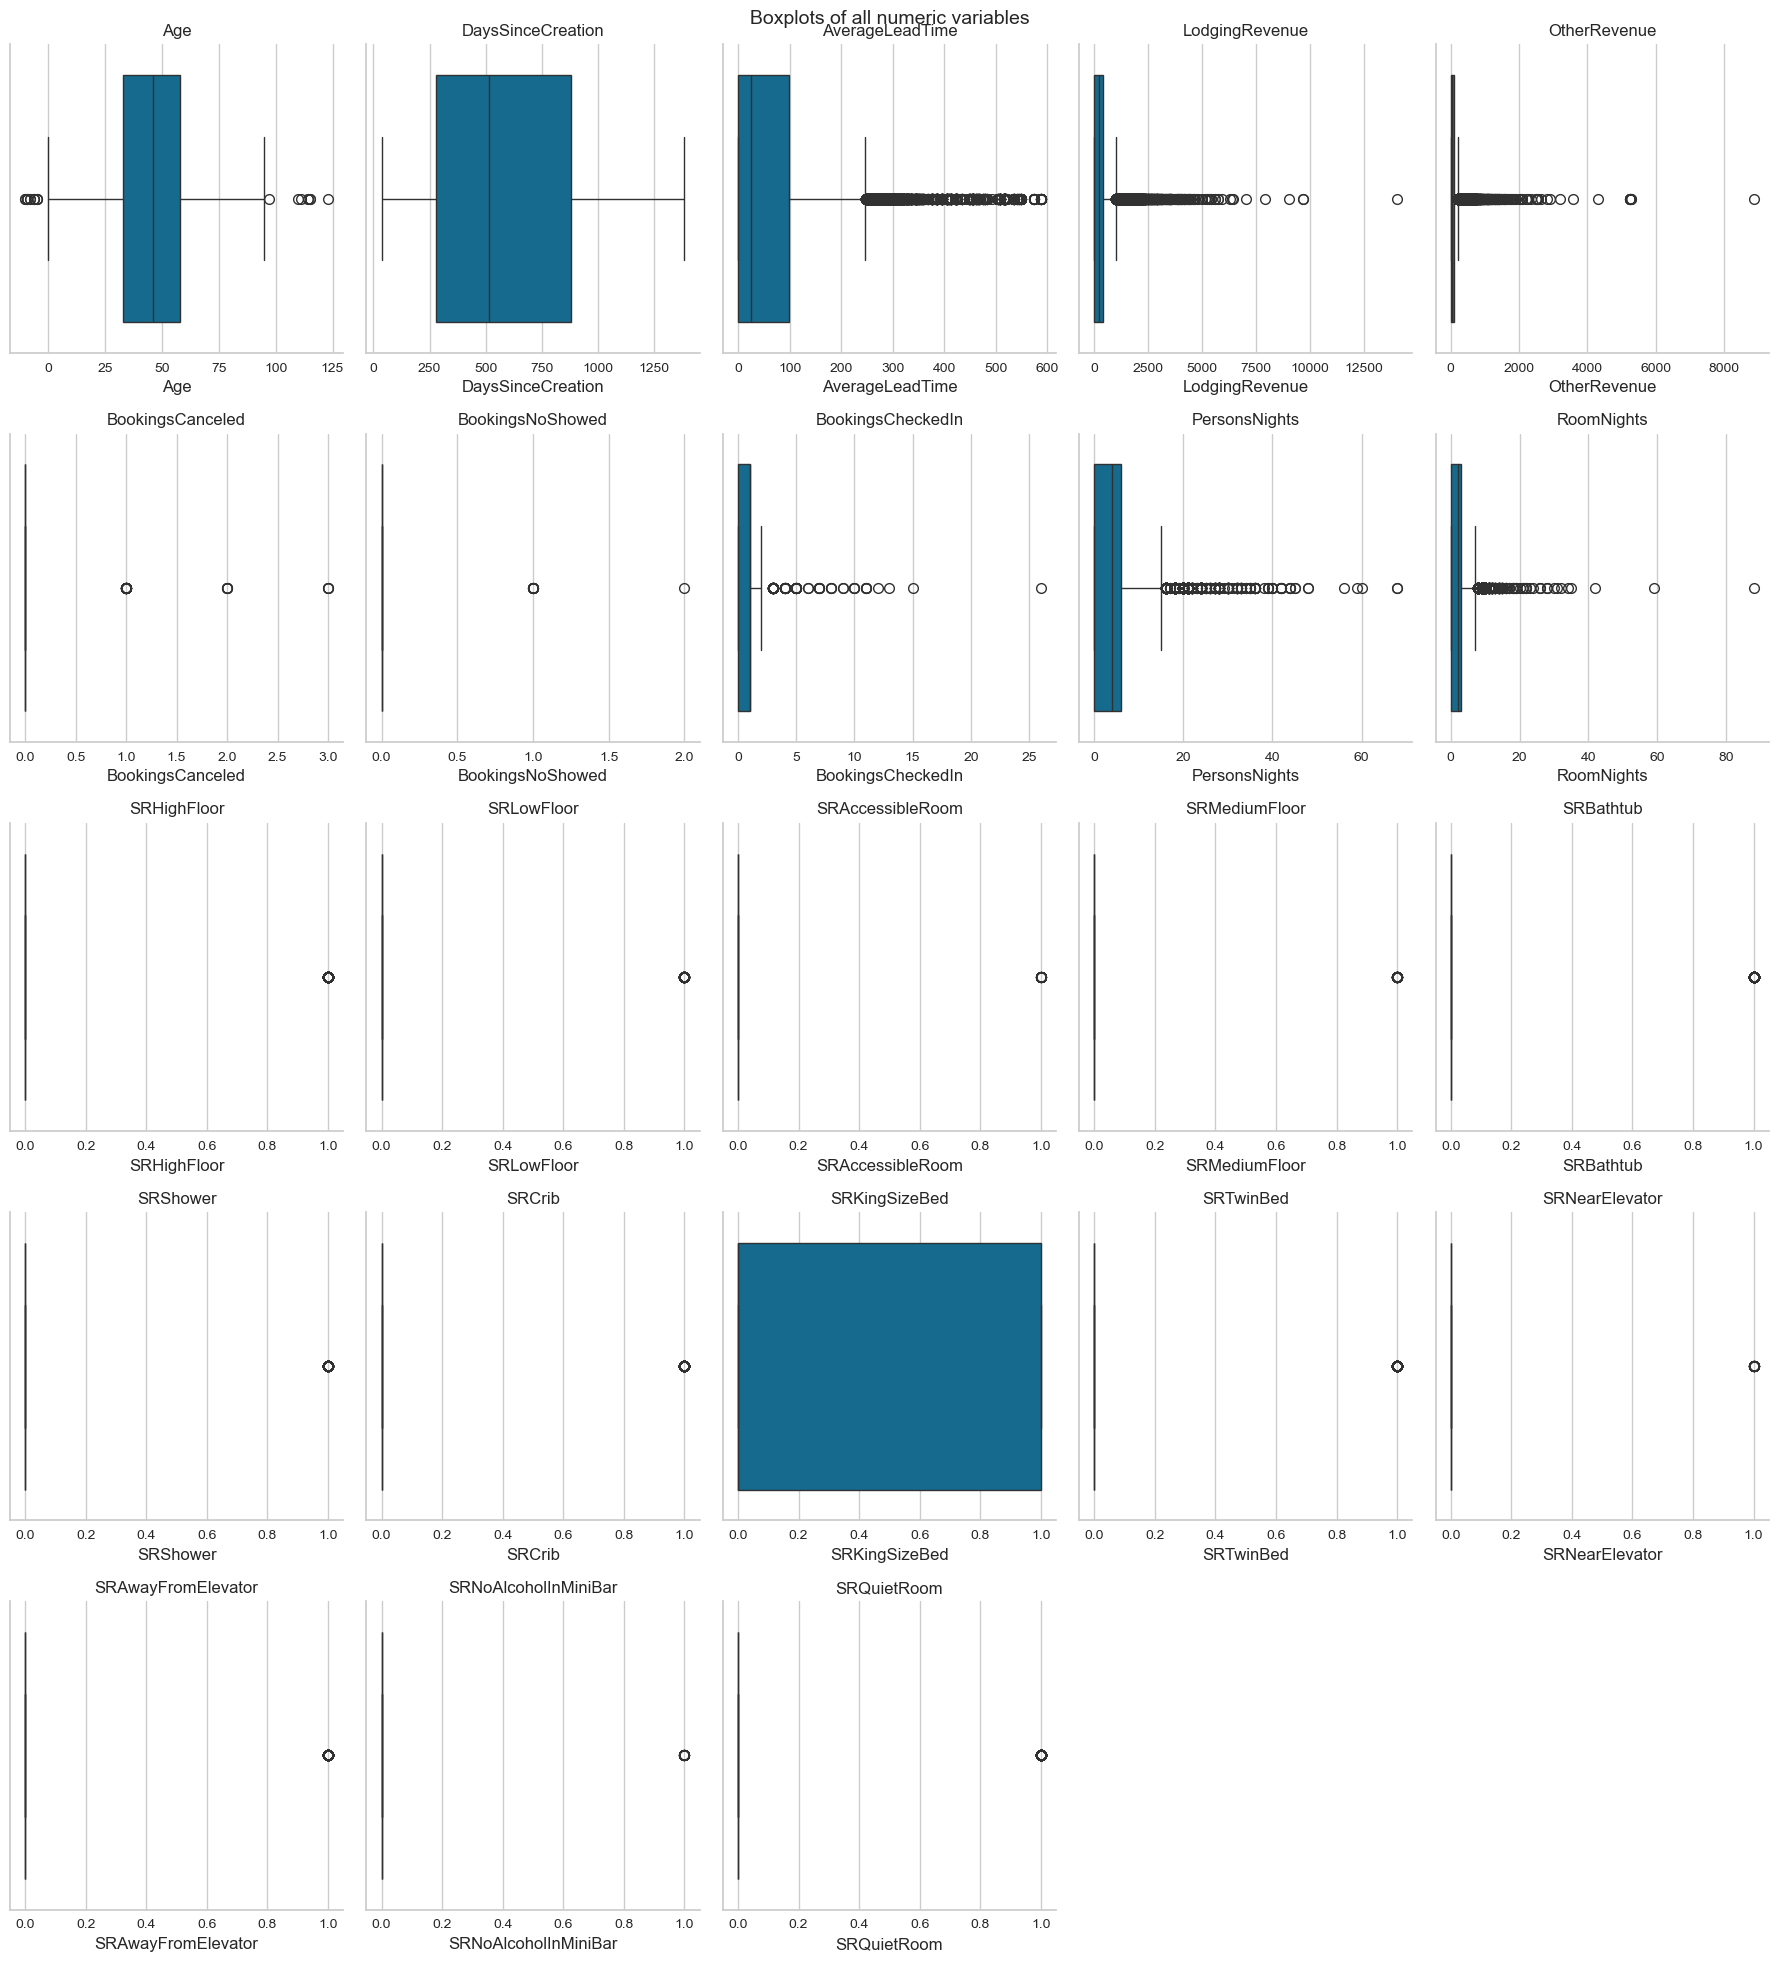

In [308]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
ax = ax.flatten()

for i, var in enumerate(numerical_data):
    sns.boxplot(data=data, x=var, ax=ax[i])
    ax[i].set_title(var, fontsize=subPlots_label_fontSize)

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

sns.despine()
fig.suptitle("Boxplots of all numeric variables", fontsize=plots_Title_fontSize)
plt.tight_layout()
plt.show()

Check if the Customer Preferences have only binary values (0 or 1)

In [309]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]

data[binary_cols] = data[binary_cols].apply(pd.to_numeric, errors='coerce')

In [310]:
for col in binary_cols:
    unique_values = data[col].unique()
    if not set(unique_values).issubset({0, 1}):
        print(f"Column {col} contains values other than 0 and 1: {unique_values}")

Distribution of the variables with binary values (0 or 1)

In [311]:
for col in binary_cols:
    print(f"Value counts for {col}:")
    print(data[col].value_counts(dropna=False))
    print("-" * 40)

Value counts for SRHighFloor:
SRHighFloor
0    96030
1     4365
Name: count, dtype: int64
----------------------------------------
Value counts for SRLowFloor:
SRLowFloor
0    100260
1       135
Name: count, dtype: int64
----------------------------------------
Value counts for SRMediumFloor:
SRMediumFloor
0    100330
1        65
Name: count, dtype: int64
----------------------------------------
Value counts for SRAccessibleRoom:
SRAccessibleRoom
0    100376
1        19
Name: count, dtype: int64
----------------------------------------
Value counts for SRBathtub:
SRBathtub
0    100065
1       330
Name: count, dtype: int64
----------------------------------------
Value counts for SRShower:
SRShower
0    100228
1       167
Name: count, dtype: int64
----------------------------------------
Value counts for SRCrib:
SRCrib
0    98735
1     1660
Name: count, dtype: int64
----------------------------------------
Value counts for SRKingSizeBed:
SRKingSizeBed
0    63518
1    36877
Name: count, 

Distribution of the categorical variables

In [312]:
categorical_cols = ["Nationality", "DistributionChannel"]
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [313]:
nationality_cols = [col for col in data.columns if col.startswith("Nationality_")]
nationality_counts = data[nationality_cols].sum().sort_values(ascending=False)
distribution_cols = [col for col in data.columns if col.startswith("DistributionChannel_")]
distribution_counts = data[distribution_cols].sum().sort_values(ascending=False)

Top 20 Nationalities

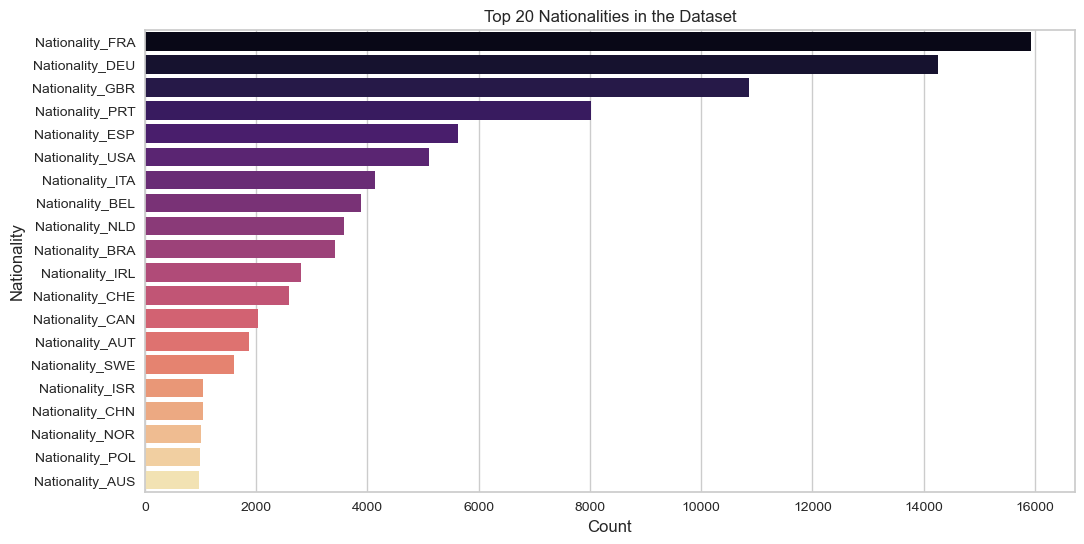

In [314]:
top_n = 20
top_nationalities = nationality_counts.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_nationalities.values, y=top_nationalities.index, palette="magma")
plt.title(f"Top {top_n} Nationalities in the Dataset")
plt.xlabel("Count")
plt.ylabel("Nationality")
plt.show()

Change Data Type

In [315]:
data[nationality_cols] = data[nationality_cols].astype(int)

Choose only the Top 5 Nationalities

In [316]:
threshold = len(data) * 0.05
nationality_counts = data[nationality_cols].sum()
top_nationalities = nationality_counts[nationality_counts > threshold].index.tolist()
data["Nationality_Processed"] = data[top_nationalities].idxmax(axis=1)
data["Nationality_Processed"] = data["Nationality_Processed"].fillna("Other")
data["Nationality_Processed"] = data["Nationality_Processed"].astype("category")
data.drop(columns=nationality_cols, inplace=True)

print(data["Nationality_Processed"].value_counts())

Nationality_Processed
Nationality_DEU    54854
Nationality_FRA    15921
Nationality_GBR    10866
Nationality_PRT     8019
Nationality_ESP     5632
Nationality_USA     5103
Name: count, dtype: int64


C:\Users\gonca\AppData\Local\Temp\ipykernel_28024\3475910094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["Nationality_Processed"] = data[top_nationalities].idxmax(axis=1)


Check Distribution of the **DistributionChannel_Direct**, **DistributionChannel_GDS Systems** and **DistributionChannel_Travel Agent/Operator** variables.

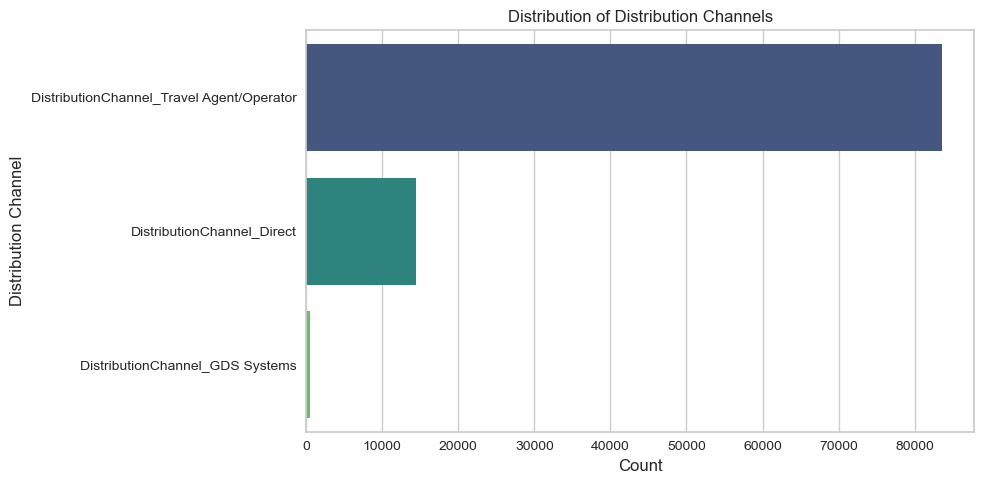

In [317]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(x=distribution_counts.values, y=distribution_counts.index, palette="viridis", ax=ax)
ax.set_title("Distribution of Distribution Channels")
ax.set_xlabel("Count")
ax.set_ylabel("Distribution Channel")

plt.tight_layout()
plt.show()

Change Data Type

In [318]:
bool_cols = ['DistributionChannel_Direct', 'DistributionChannel_GDS Systems', 'DistributionChannel_Travel Agent/Operator']
data[bool_cols] = data[bool_cols].astype(int)

**BookingsNoShowed** & **BookingsCheckedIn** Handling

In [319]:
print(data['BookingsNoShowed'].value_counts())

BookingsNoShowed
0    100385
1         9
2         1
Name: count, dtype: int64


In [320]:
print(data['BookingsCheckedIn'].value_counts())

BookingsCheckedIn
1     68554
0     30502
2      1190
3        95
4        16
5        15
7         5
11        4
8         3
10        3
6         2
9         2
12        1
26        1
13        1
15        1
Name: count, dtype: int64


Since the BookingsNoShowed variable is highly imbalanced, we can simplify it into a binary feature:

- 0 → Never No-Showed
- 1 or more → At Least One No-Show

In [321]:
data["HasNoShow"] = (data["BookingsNoShowed"] > 0).astype(int)

Since almost all customers have 0 canceled bookings, we can simplify it:

- 0 → Never canceled
- 1 or more → At least one cancellation

In [322]:
data["HasCanceled"] = (data["BookingsCanceled"] > 0).astype(int)

For **BookingsCheckedIn** the people who never checked in were removed.

In [323]:
data = data[data['BookingsCheckedIn'] != 0]

print(f"Final dataset size after removing rows with BookingsCheckedIn = 0: {data.shape[0]} rows")

Final dataset size after removing rows with BookingsCheckedIn = 0: 69893 rows


### Correlation Matrix

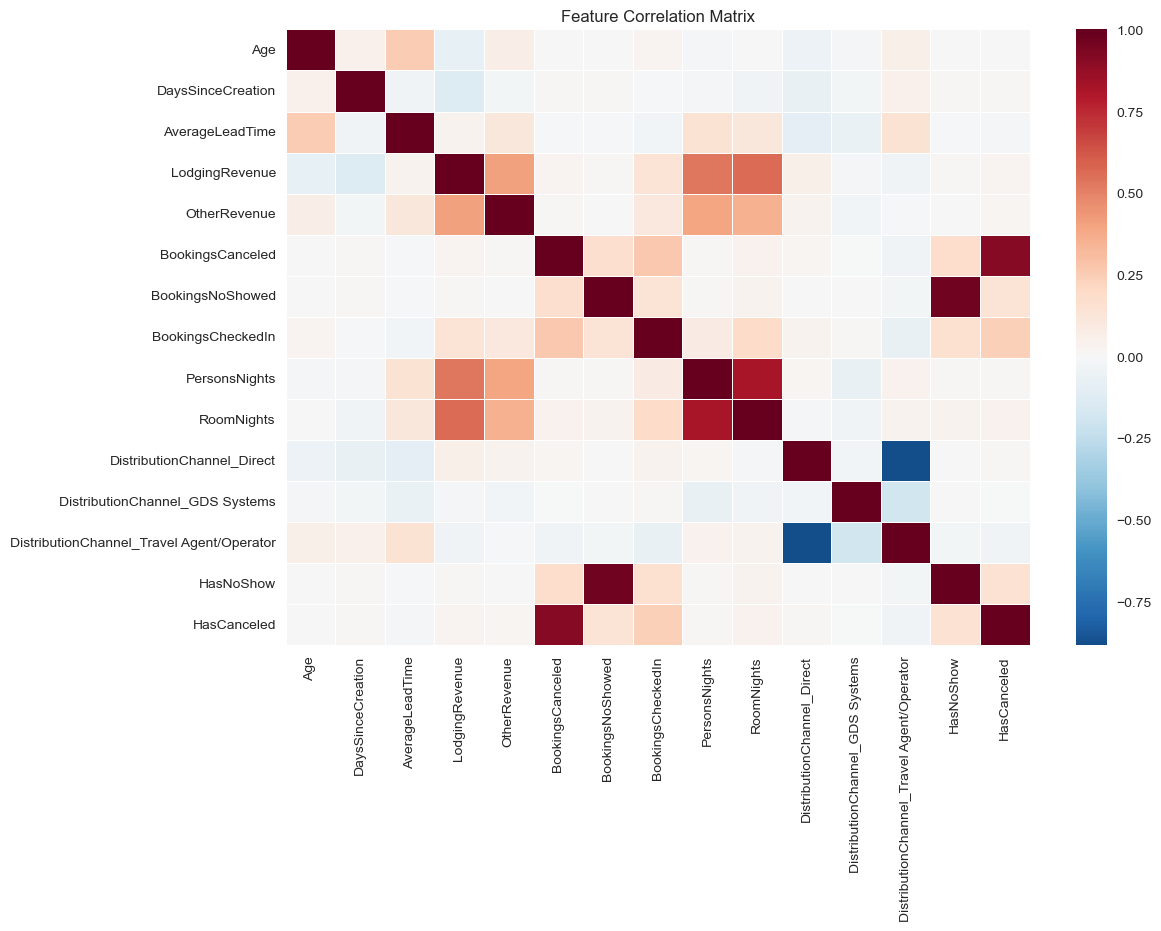

In [324]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]
num_cols = [col for col in data.select_dtypes(include=["number"]).columns if col not in binary_cols]
corr_matrix = data[num_cols].corr()

plt.figure(figsize=(12, 8)) 
sns.heatmap(
    corr_matrix, 
    annot=False,  
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5
)
plt.title("Feature Correlation Matrix")
plt.show()

# Data Preparation

### Missing Values Handling

In [325]:
data['Age'] = data['Age'].fillna(data['Age'].median())

In [326]:
print(data.isnull().sum())

Age                                          0
DaysSinceCreation                            0
NameHash                                     0
DocIDHash                                    0
AverageLeadTime                              0
LodgingRevenue                               0
OtherRevenue                                 0
BookingsCanceled                             0
BookingsNoShowed                             0
BookingsCheckedIn                            0
PersonsNights                                0
RoomNights                                   0
MarketSegment                                0
SRHighFloor                                  0
SRLowFloor                                   0
SRAccessibleRoom                             0
SRMediumFloor                                0
SRBathtub                                    0
SRShower                                     0
SRCrib                                       0
SRKingSizeBed                                0
SRTwinBed    

Remove Negative Values

In [327]:
numerical_cols = data.select_dtypes(include=['number']).columns
data[numerical_cols] = data[numerical_cols].clip(lower=0)

In [328]:
negative_values = (data[numerical_cols] < 0).sum()
print("Negative values after correction:\n", negative_values)

Negative values after correction:
 Age                                          0
DaysSinceCreation                            0
AverageLeadTime                              0
LodgingRevenue                               0
OtherRevenue                                 0
BookingsCanceled                             0
BookingsNoShowed                             0
BookingsCheckedIn                            0
PersonsNights                                0
RoomNights                                   0
SRHighFloor                                  0
SRLowFloor                                   0
SRAccessibleRoom                             0
SRMediumFloor                                0
SRBathtub                                    0
SRShower                                     0
SRCrib                                       0
SRKingSizeBed                                0
SRTwinBed                                    0
SRNearElevator                               0
SRAwayFromElevator       

### Outliers Handling

In [329]:
data = data[((data['Age'] >= 0) & (data['Age'] <= 100))]

Outliers in (PersonsNights < RoomNights)

In [330]:
invalid_rows = data[data['PersonsNights'] < data['RoomNights']]
data = data[data['PersonsNights'] >= data['RoomNights']]

print(f"Rows eliminated due to PersonsNights < RoomNights: {invalid_rows.shape[0]}")

Rows eliminated due to PersonsNights < RoomNights: 12


Cap and Log Transformation

In [331]:
zero_count = (data["LodgingRevenue"] == 0).sum()
print(f"Number of zero values in LodgingRevenue: {zero_count}")
zero_percentage = (data["LodgingRevenue"] == 0).mean() * 100
print(f"Percentage of zero values in LodgingRevenue: {zero_percentage:.2f}%")
other_zero_count = (data["OtherRevenue"] == 0).sum()
print(f"Number of zero values in OtherRevenue: {other_zero_count}")

Number of zero values in LodgingRevenue: 304
Percentage of zero values in LodgingRevenue: 0.44%
Number of zero values in OtherRevenue: 182


In [332]:
data["LodgingRevenue"] = data["LodgingRevenue"].clip(upper=6000)
data["OtherRevenue"] = data["OtherRevenue"].clip(upper=3000)
data["AverageLeadTime"] = data["AverageLeadTime"].clip(upper=300)
data["PersonsNights"] = data["PersonsNights"].clip(upper=35)
data["RoomNights"] = data["RoomNights"].clip(upper=30)

In [333]:
data["LodgingRevenue_Log"] = np.log1p(data["LodgingRevenue"])
data["OtherRevenue_Log"] = np.log1p(data["OtherRevenue"])
data["AverageLeadTime_Log"] = np.log1p(data["AverageLeadTime"])
data["PersonsNights_Log"] = np.log1p(data["PersonsNights"])
data["RoomNights_Log"] = np.log1p(data["RoomNights"])
data["Log_BookingsCheckedIn"] = np.log1p(data["BookingsCheckedIn"])

### Correlation Matrix (After Clip and Log Transformation)

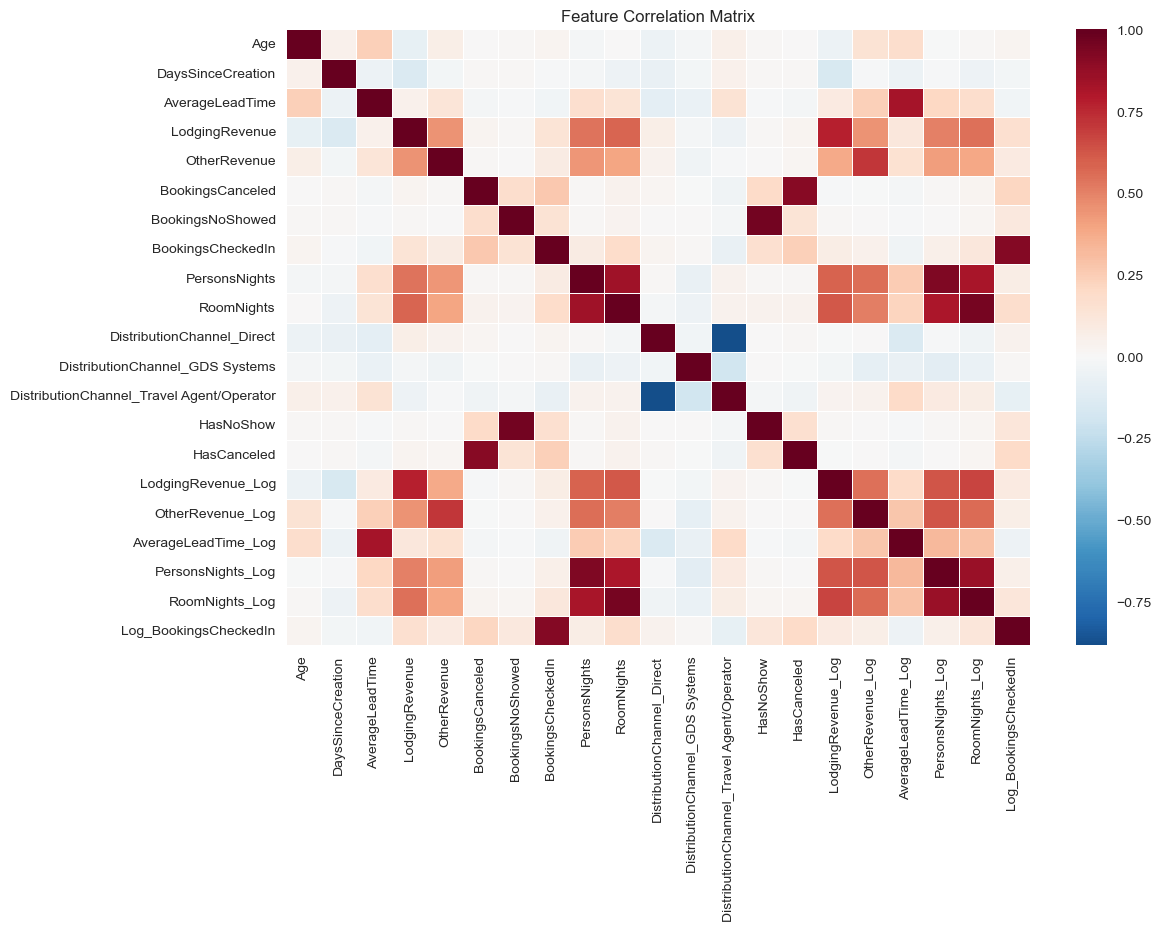

In [334]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]
num_cols = [col for col in data.select_dtypes(include=["number"]).columns if col not in binary_cols]
corr_matrix = data[num_cols].corr()

plt.figure(figsize=(12, 8)) 
sns.heatmap(
    corr_matrix, 
    annot=False,  
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5
)
plt.title("Feature Correlation Matrix")
plt.show()

### Outliers Check

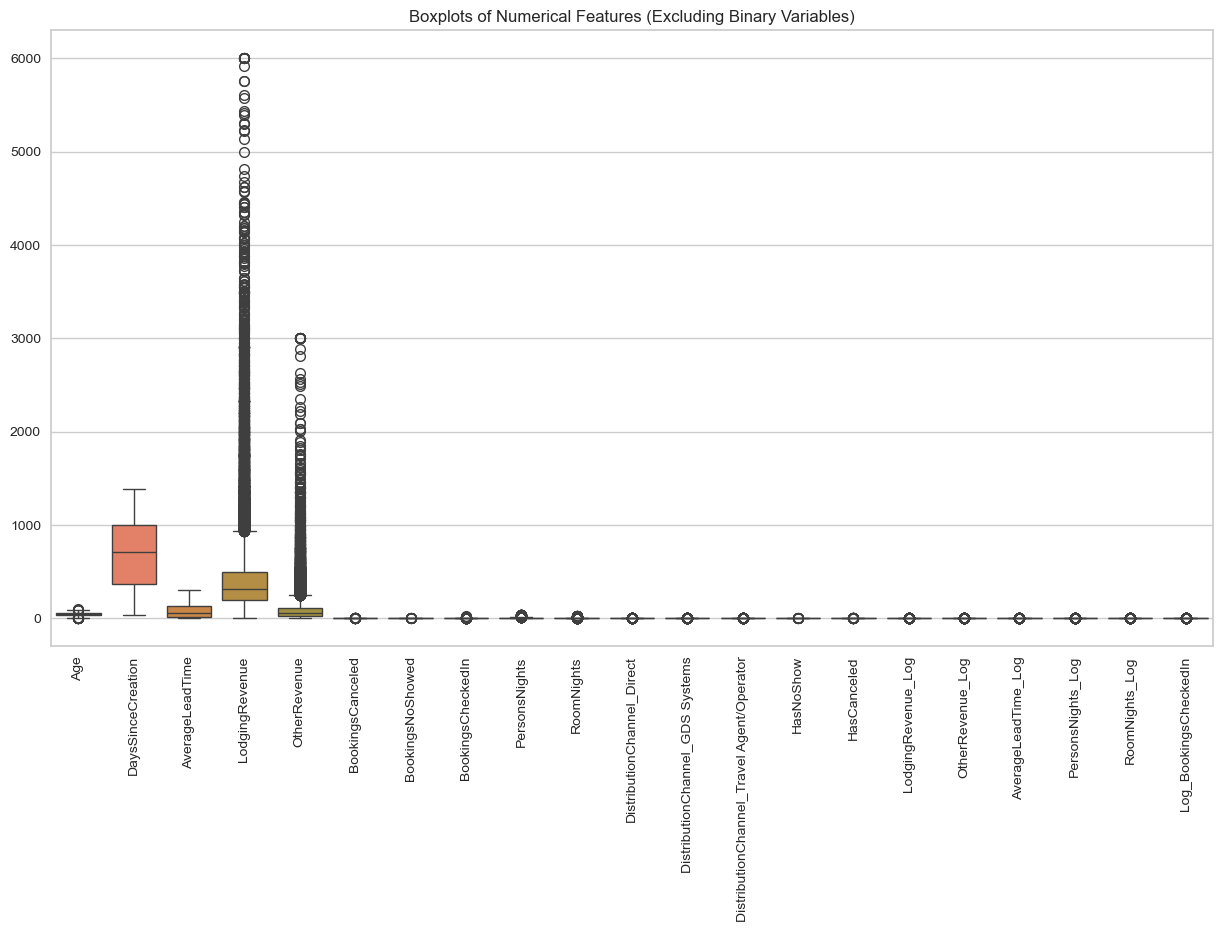

In [335]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]
num_cols = [col for col in data.select_dtypes(include=["number"]).columns if col not in binary_cols]

plt.figure(figsize=(15, 8))
sns.boxplot(data=data[num_cols])
plt.xticks(rotation=90)
plt.title("Boxplots of Numerical Features (Excluding Binary Variables)")
plt.show()

### Merge Features based on the Correlation

In [336]:
data["TotalNights_Log"] = data["PersonsNights_Log"] + data["RoomNights_Log"]
data.drop(columns=["PersonsNights_Log", "RoomNights_Log"], inplace=True)

In [337]:
data["TotalRevenue_Log"] = data["LodgingRevenue_Log"] + data["OtherRevenue_Log"]
data.drop(columns=["LodgingRevenue_Log", "OtherRevenue_Log"], inplace=True)

In [338]:
drop_cols = ['SRHighFloor', 'SRLowFloor', 'SRAccessibleRoom', 'SRMediumFloor',
            'SRBathtub', 'SRShower', 'SRCrib', 'SRKingSizeBed', 'SRTwinBed',
            'SRNearElevator', 'SRAwayFromElevator', 'SRNoAlcoholInMiniBar', 'SRQuietRoom', 'LodgingRevenue', 'OtherRevenue', 'AverageLeadTime', 
            'PersonsNights', 'RoomNights', 'NameHash', 'DocIDHash', 'MarketSegment', 'BookingsNoShowed', 'BookingsCanceled', 
            'BookingsCheckedIn', 'HasNoShow', 'HasCanceled']

if "Nationality_Processed" in data.columns:
    data.drop(columns=["Nationality_Processed"], inplace=True)

data.drop(columns=drop_cols, inplace=True)
print("Final feature list:")
print(data.columns)
print("Total number of columns:", len(data.columns))

Final feature list:
Index(['Age', 'DaysSinceCreation', 'DistributionChannel_Direct',
       'DistributionChannel_GDS Systems',
       'DistributionChannel_Travel Agent/Operator', 'AverageLeadTime_Log',
       'Log_BookingsCheckedIn', 'TotalNights_Log', 'TotalRevenue_Log'],
      dtype='object')
Total number of columns: 9


## 📌 Final Variables

- **`Age`** → Customer's age  
- **`DaysSinceCreation`** → Time since account creation  
- **`DistributionChannel_Direct`** → Whether the booking channel was direct (binary)  
- **`DistributionChannel_GDS Systems`** → Whether the booking was made through GDS systems (binary)  
- **`DistributionChannel_Travel Agent/Operator`** → Whether the booking was made via a travel agent or operator (binary)  
- **`Log_BookingsCheckedIn`** → Number of successfully completed bookings (log-transformed)  
- **`AverageLeadTime_Log`** → Average lead time before booking (log-transformed)  
- **`TotalNights_Log`** → Total nights booked (log-transformed)  
- **`TotalRevenue_Log`** → Total revenue generated by the customer (log-transformed)  

### Standard Scaling

In [339]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
df_scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

### PCA

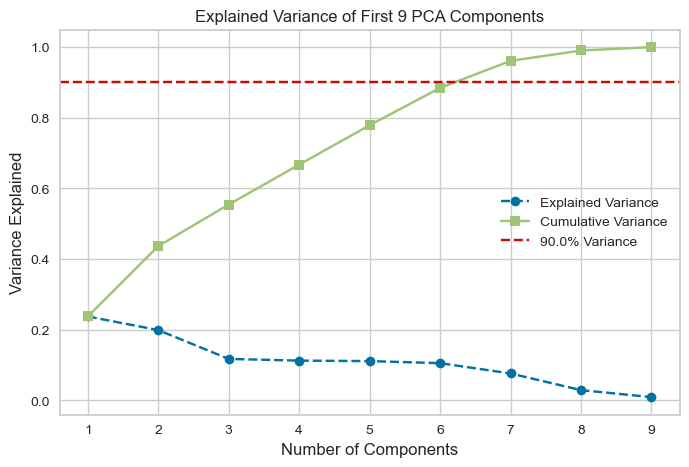

Total variance explained by 9 components: 1.0000


In [344]:
pca = PCA(n_components=9)
data_pca = pca.fit_transform(scaled_data)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label='Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', label='Cumulative Variance')

threshold_var = 0.90  
plt.axhline(y=threshold_var, color='r', linestyle='--', label=f'{threshold_var*100}% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance of First 9 PCA Components')
plt.legend()
plt.show()

total_variance = sum(explained_variance)
print(f"Total variance explained by 9 components: {total_variance:.4f}")
if total_variance < threshold_var:
    print(f"Warning: Less than {threshold_var*100}% variance is explained! Consider increasing n_components.")

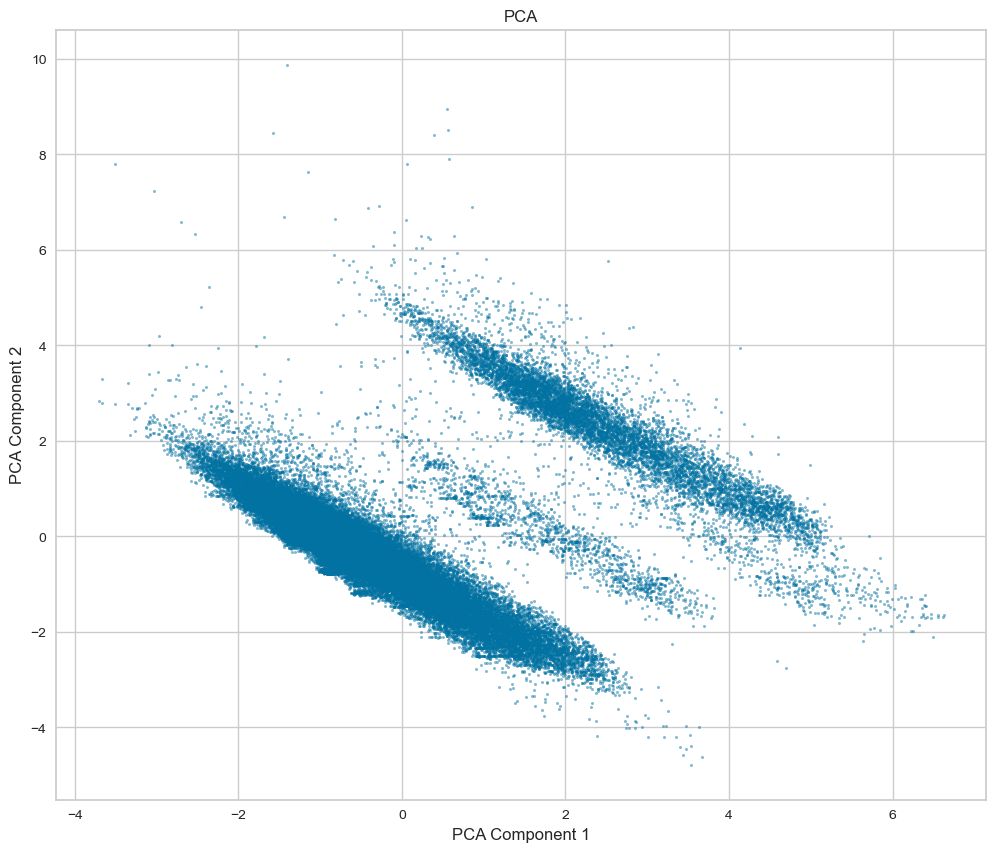

In [345]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(data_pca[:, 0], data_pca[:, 1], s=3, alpha=0.5)
ax.set_title(f"PCA")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
plt.show()

In [346]:
pca_columns = [f"PC{i+1}" for i in range(9)]
df_pca = pd.DataFrame(data_pca, columns=pca_columns)

print(df_pca.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.569799  2.286463  0.523790  2.638946  4.091889  2.211866  1.514115   
1 -1.147633 -0.186179 -1.449280 -0.185197  0.656952 -1.216944  0.153977   
2 -0.046335 -1.254082 -1.299548 -0.246196  0.657296 -0.913078  0.447475   
3 -0.958944  0.089774  0.173454 -0.973058  1.010402 -1.845152  0.182277   
4 -0.397831 -0.662478  0.185150 -1.006564  0.715496 -1.587373  1.250835   

        PC8       PC9  
0  0.029385  1.725782  
1  0.752985 -0.000599  
2 -0.016703 -0.062279  
3  0.137039 -0.022186  
4 -0.028317 -0.037131  


### Check if Clusters Exist (PCA)

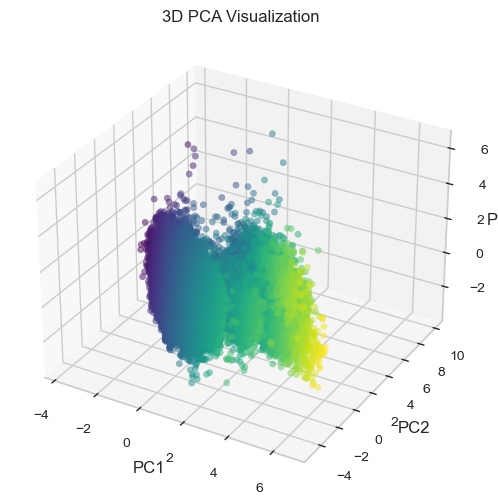

PCA Reduced Data Shape: (69877, 9)


In [347]:
pca_3d = PCA(n_components=3)
data_pca_3d = pca_3d.fit_transform(scaled_data)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2], c=data_pca_3d[:, 0], cmap='viridis', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Visualization')
plt.show()

print(f"PCA Reduced Data Shape: {data_pca.shape}")

### UMAP

c:\Users\gonca\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


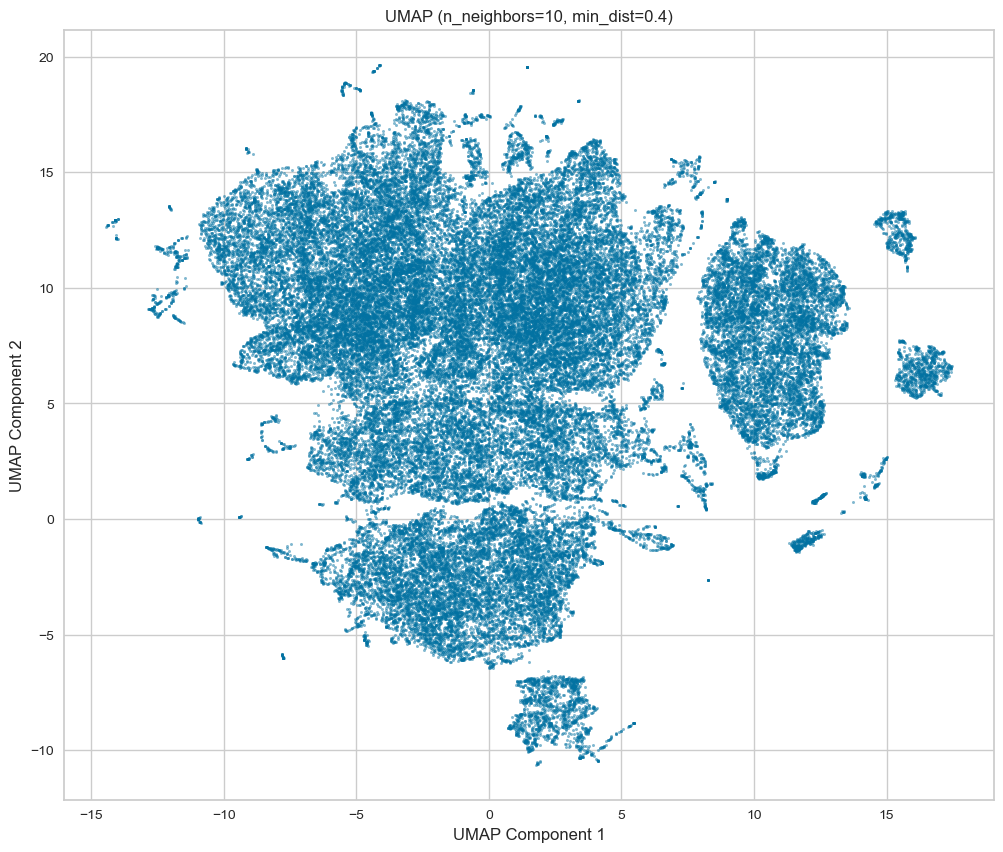

In [348]:
n_neighbors = 10
min_dist = 0.4
umap_reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=123)
data_umap = umap_reducer.fit_transform(scaled_data)

fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(data_umap[:, 0], data_umap[:, 1], s=3, alpha=0.5)
ax.set_title(f"UMAP (n_neighbors={n_neighbors}, min_dist={min_dist})")
ax.set_xlabel("UMAP Component 1")
ax.set_ylabel("UMAP Component 2")
plt.show()

### Comparing PCA and UMAP

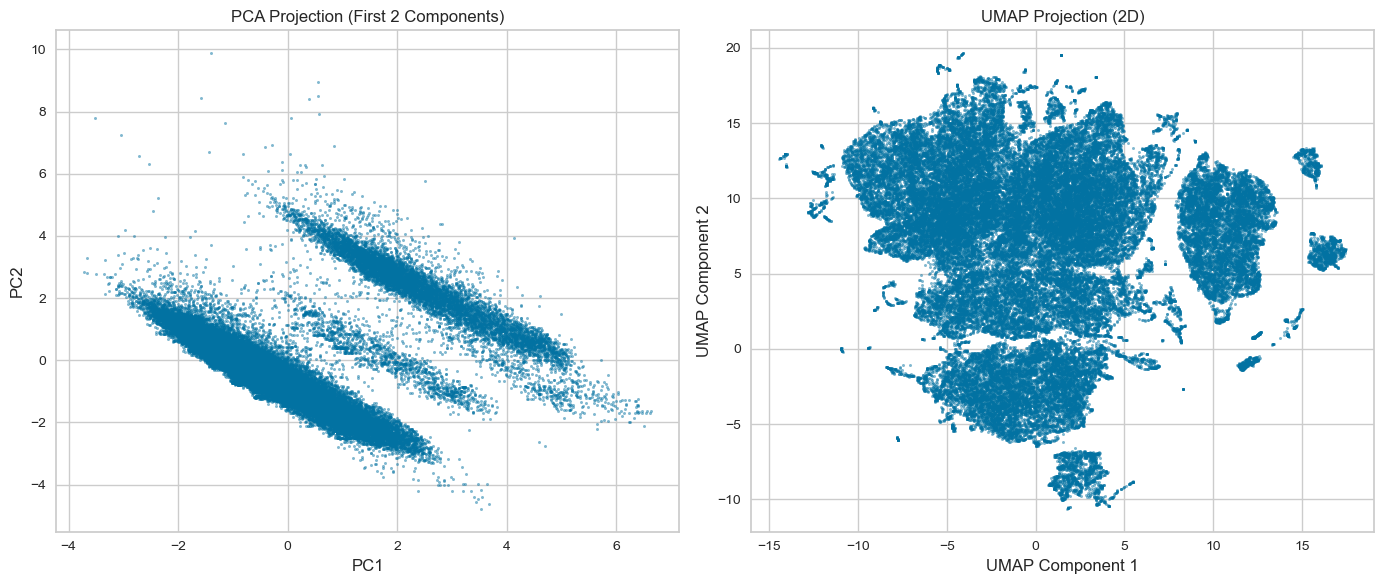

In [349]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA Scatter Plot
axes[0].scatter(data_pca[:, 0], data_pca[:, 1], s=3, alpha=0.5)
axes[0].set_title("PCA Projection (First 2 Components)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# UMAP Scatter Plot
axes[1].scatter(data_umap[:, 0], data_umap[:, 1], s=3, alpha=0.5)
axes[1].set_title("UMAP Projection (2D)")
axes[1].set_xlabel("UMAP Component 1")
axes[1].set_ylabel("UMAP Component 2")

plt.tight_layout()
plt.show()

# Clustering

### K-Means

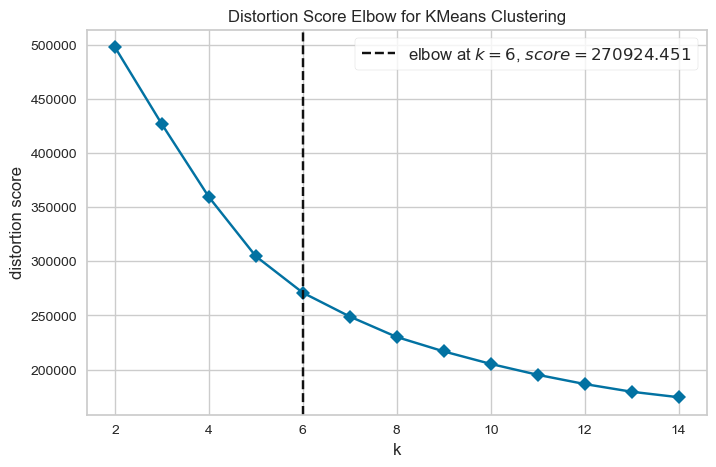

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [350]:
kmeans = KMeans(random_state=123, n_init=10)
plt.figure(figsize=(8, 5))
visualizer = KElbowVisualizer(kmeans, k=(2, 15), metric='distortion', timings=False)
visualizer.fit(scaled_data)
visualizer.show()

In [ ]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=123, n_init=10)
df_scaled_data["Cluster"] = kmeans.fit_predict(df_scaled_data)

Cluster
0    21651
2    21625
1    15973
4     8826
5     1317
3      485
Name: count, dtype: int64


,Age,DaysSinceCreation,DistributionChannel_Direct,DistributionChannel_GDS Systems,DistributionChannel_Travel Agent/Operator,AverageLeadTime_Log,Log_BookingsCheckedIn,TotalNights_Log,TotalRevenue_Log,Cluster
ID,,,,,,,,,,
1,52.0,440,0,0,0,4.094345,1.098612,3.555348,10.102621,0.0
4,61.0,1385,0,0,1,4.543295,0.693147,4.189655,9.595671,2.0
6,55.0,1385,0,0,1,4.077537,0.693147,2.708050,8.661294,4.0
8,33.0,1385,0,0,1,3.663562,0.693147,4.189655,10.838011,0.0
10,26.0,1385,0,0,1,4.574711,0.693147,3.332205,9.413281,4.0


In [ ]:
print(df_scaled_data["Cluster"].value_counts())
data["Cluster"] = df_scaled_data["Cluster"]
data.head()

In [352]:
silhouette_score_minmax = silhouette_score(df_scaled_data.drop(columns=["Cluster"]), df_scaled_data["Cluster"])
print(f"Silhouette Score: {silhouette_score_minmax:.4f}")

Silhouette Score: 0.2107


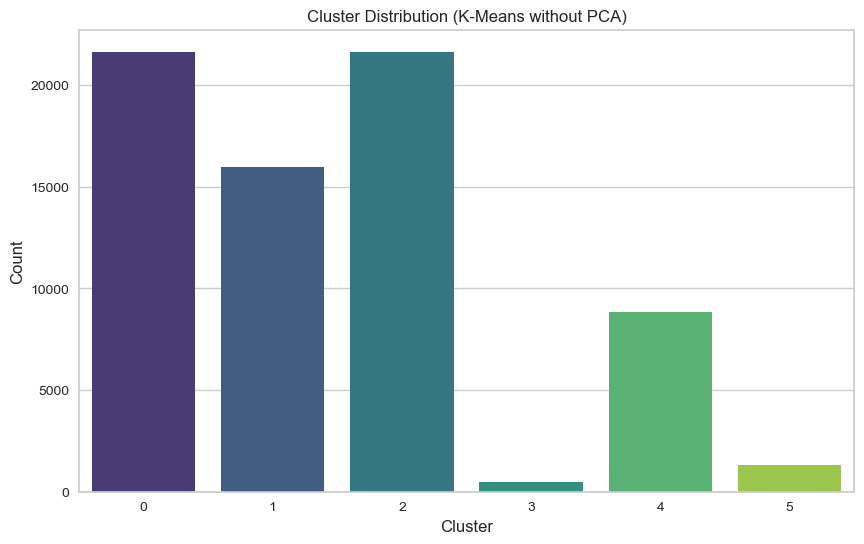

In [353]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df_scaled_data["Cluster"], palette="viridis")
plt.title("Cluster Distribution (K-Means without PCA)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

In [354]:
cluster_means = data.groupby("Cluster").mean()
print(cluster_means)

               Age  DaysSinceCreation  DistributionChannel_Direct  \
Cluster                                                             
0.0      48.173231         942.013372                    0.113391   
1.0      48.924340         908.492255                    0.118894   
2.0      48.215132         793.134658                    0.125662   
3.0      47.917178         784.828221                    0.119632   
4.0      48.223921         829.960020                    0.122795   
5.0      47.595519         786.805425                    0.135613   

         DistributionChannel_GDS Systems  \
Cluster                                    
0.0                             0.004702   
1.0                             0.004936   
2.0                             0.006904   
3.0                             0.006135   
4.0                             0.006047   
5.0                             0.010613   

         DistributionChannel_Travel Agent/Operator  AverageLeadTime_Log  \
Cluster            

### K-Means with PCA

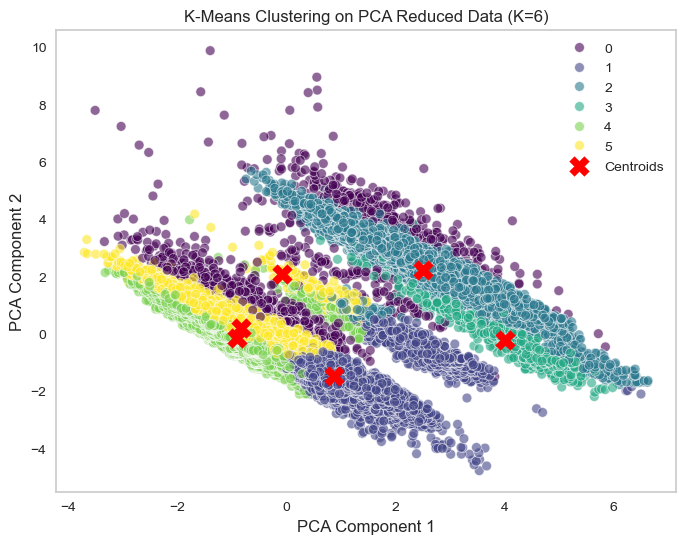

Cluster Distribution: {0: 1317, 1: 15869, 2: 8906, 3: 485, 4: 21576, 5: 21724}


In [355]:
n_pca_components = 6
pca = PCA(n_components=n_pca_components)
data_pca = pca.fit_transform(scaled_data)
kmeans_pca = KMeans(n_clusters=6, random_state=123, n_init=10)
y_kmeans_pca = kmeans_pca.fit_predict(data_pca)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=y_kmeans_pca, palette="viridis", alpha=0.6)
plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], s=200, c="red", marker="X", label="Centroids")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering on PCA Reduced Data (K=6)")
plt.legend()
plt.grid()
plt.show()

unique, counts = np.unique(y_kmeans_pca, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print(f"Cluster Distribution: {cluster_distribution}")

In [356]:
silhouette_avg = silhouette_score(data_pca, y_kmeans_pca)
print(f"Silhouette Score with PCA: {silhouette_avg:.4f}")

Silhouette Score with PCA: 0.2617


In [357]:
pca_cluster_means = pd.DataFrame(kmeans_pca.cluster_centers_, columns=[f"PC{i+1}" for i in range(n_pca_components)])
print(pca_cluster_means)

        PC1       PC2       PC3       PC4       PC5       PC6
0 -0.081810  2.081044  0.773369  2.633550  5.144699  2.246539
1  0.872251 -1.493573  0.159998 -0.180816  0.180358  0.159166
2  2.495529  2.239586 -0.519191 -0.536152 -0.351569  0.056542
3  4.009030 -0.223387  2.540922  9.280827 -2.459724 -6.009812
4 -0.916919 -0.157299 -0.842297  0.275850 -0.133028  0.016153
5 -0.836416  0.209810  0.829120 -0.288831 -0.112838 -0.157845


### K-Means with UMAP

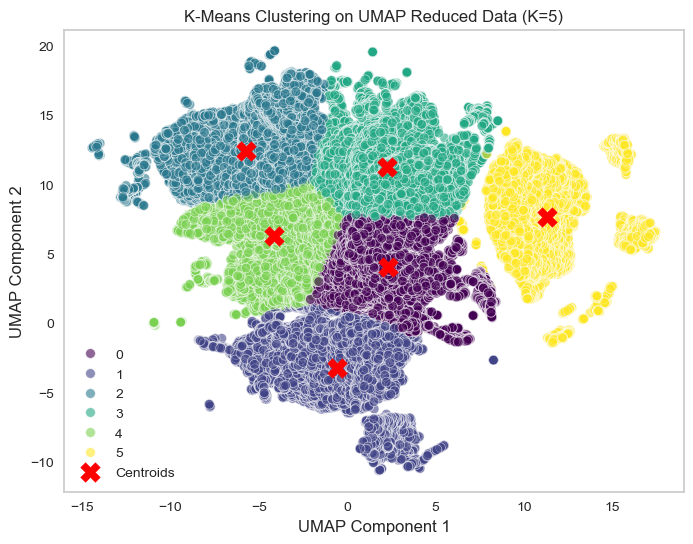

Cluster Distribution: {0: 8867, 1: 12067, 2: 12574, 3: 14203, 4: 11478, 5: 10688}


In [358]:
kmeans_umap = KMeans(n_clusters=6, random_state=123, n_init=10)
y_kmeans_umap = kmeans_umap.fit_predict(data_umap)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_umap[:, 0], y=data_umap[:, 1], hue=y_kmeans_umap, palette="viridis", alpha=0.6)
plt.scatter(kmeans_umap.cluster_centers_[:, 0], kmeans_umap.cluster_centers_[:, 1], s=200, c="red", marker="X", label="Centroids")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("K-Means Clustering on UMAP Reduced Data (K=5)")
plt.legend()
plt.grid()
plt.show()

unique, counts = np.unique(y_kmeans_umap, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print(f"Cluster Distribution: {cluster_distribution}")

In [362]:
silhouette_avg = silhouette_score(data_umap, y_kmeans_umap)
print(f"Silhouette Score with PCA: {silhouette_avg:.4f}")

Silhouette Score with PCA: 0.3916


In [359]:
if "Cluster_UMAP" not in df_scaled_data.columns:
    kmeans_umap = KMeans(n_clusters=6, random_state=123, n_init=10)
    df_scaled_data["Cluster_UMAP"] = kmeans_umap.fit_predict(data_umap)

In [360]:
columns_to_exclude = ["Cluster", "Cluster_UMAP"]
features_only = df_scaled_data.drop(columns=[col for col in columns_to_exclude if col in df_scaled_data.columns])
cluster_means = features_only.groupby(df_scaled_data["Cluster_UMAP"]).mean()

print("Feature means per cluster:\n", cluster_means)

Feature means per cluster:
                    Age  DaysSinceCreation  DistributionChannel_Direct  \
Cluster_UMAP                                                            
0            -0.176673          -0.842148                   -0.387118   
1            -0.059747           0.145282                   -0.387118   
2             0.294420           0.824459                   -0.387118   
3             0.199527          -0.819401                   -0.387118   
4            -0.274276           0.787938                   -0.387118   
5            -0.102943          -0.192603                    2.143816   

              DistributionChannel_GDS Systems  \
Cluster_UMAP                                    
0                                   -0.083689   
1                                   -0.083689   
2                                   -0.083689   
3                                   -0.083689   
4                                   -0.083689   
5                                    0.46345

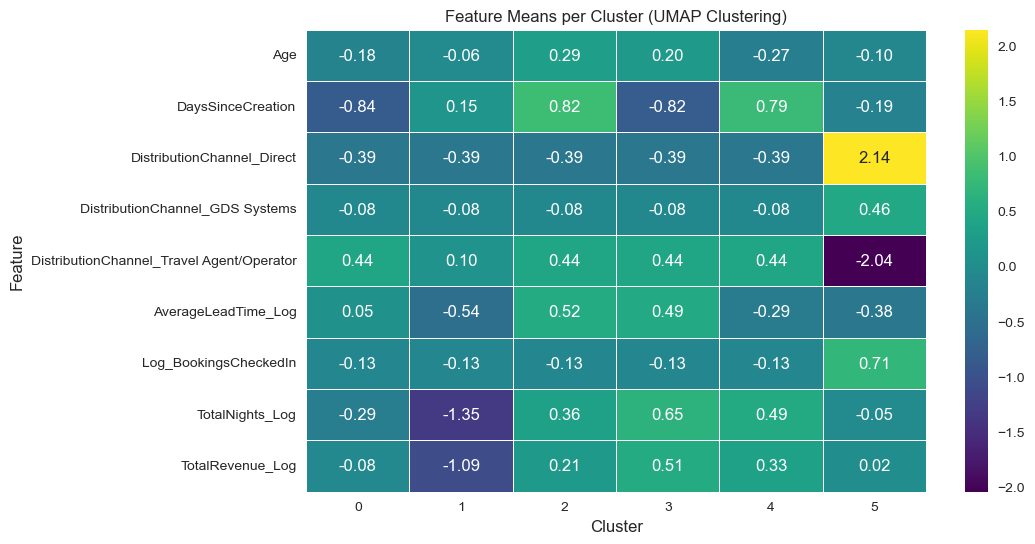

In [361]:
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.T, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5)
plt.title("Feature Means per Cluster (UMAP Clustering)")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.show()

## Cluster Analysis
##### Cluster 0:

- Recently Onboarded: This group consists of new customers who have recently joined.
- Preference for Travel Agents: These customers prefer working with travel agents or operators, indicating they value personalized assistance when planning their trips.
- Lower Spending: Their spending and trip duration is low, showing they are conservative spenders regarding travel.

##### Cluster 1:

- Minimal Engagement: This group shows very low total nights and very low total revenue, indicating low engagement and spending on travel.
- Short Planning Time: They have a short lead time, meaning they make last-minute bookings and may not engage deeply in planning.
- Low Value: These customers contribute less financially, making them less valuable.

##### Cluster 2:

- Long-term Customers: This group consists of customers who have been using the service for an extended period, indicating they have established relationships with the brand or platform.
- Thorough Planning: They have the longest lead time of any cluster, meaning they are meticulous planners who like to arrange their trips well in advance, showing a preference for preparing and organizing their travel plans early on.
- Preference for Travel Agents: Most of them prefer working with travel agents, indicating a reliance on personalized booking assistance.
- Moderate Spending: Their spending habits are moderate, reflecting a balanced approach to travel.

##### Cluster 3:

- Preference for Travel Agents: Most of them prefer working with travel agents, indicating a reliance on personalized booking assistance.
- High Planning Time: They have a long lead time, showing they plan their trips well in advance.
- High Spending: This group has very high total nights and very high total revenue, indicating they are the biggest spenders and most engaged.

##### Cluster 4:

- Good Spending: Although their total nights and revenue are not the highest, they show good spending habits, indicating that they are willing to invest in their travel experience.
- Preference for Travel Agents: They prefer working with travel agents, indicating they value personalized service and assistance.
- Shorter Planning Time: They have a relative short lead time, showing a tendency for more spontaneous booking decisions compared to others.
- Long-Term Engagement: They have been using the service for a long time, indicating strong loyalty and long-term relationship.

##### Cluster 5:

- Traditional Booking Methods: They prefer more conventional, established booking channels, global distribution systems, suggesting they value familiar, trusted channels for making their travel arrangements.
- Despite having a high amount of checked ins, have a low total revenue and total nights.
- Moderate Trip Duration: They tend to take moderate-length trips and spend an average amount on travel.
- Balanced Engagement:  Neutral or Minimal level of engagement.
- Preference for Direct Booking: Despite the lower engagement, they prefer direct booking methods, indicating a preference for self-service and more - independent travel planning.